## Set up the drive path

In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [5]:
ls

adc.json  drive/  sample_data/


In [6]:
cd drive/DCNN_100_epoch_2

/content/drive/DCNN_100_epoch_2


## Import Library

In [0]:
import collections
import os
import sys

import tensorflow as tf
import numpy as np

from tensorflow.contrib.seq2seq import sequence_loss

import math
import re
import matplotlib.pyplot as plt

import pickle

!pip install -q mosestokenizer
from mosestokenizer import *

from nltk.translate.bleu_score import sentence_bleu


from scipy.stats import multivariate_normal
from scipy.stats import norm
import copy

## Data Pre-processing

In [0]:
## load vocab dict from txt file

f = open("../dictionary/en_word_to_id.txt", "rb")
en_word_to_id = pickle.load(f)
f.close()

f = open("../dictionary/fr_word_to_id.txt", "rb")
fr_word_to_id = pickle.load(f)
f.close()

In [9]:
en_vocab_size = len(en_word_to_id)
fr_vocab_size = len(fr_word_to_id)

en_eos = en_word_to_id['eos']
fr_eos = fr_word_to_id['eos']

print(en_vocab_size)
print(fr_vocab_size)

30772
39578


In [0]:
def _read_words(filename):
  with tf.gfile.GFile(filename, "r") as f: 
    output = f.read().replace("\n", " eos ").replace(".", " .")
    output = re.sub('[0-9]+', 'N', output)
    return output

def _file_to_word_ids(data, word_to_id):
  
  id_list = []
  
  for word in data:
    if word in word_to_id:
      id_list.append(word_to_id[word])
    else:
      id_list.append(1)
          
  return id_list


def preprocess_train_data(pre_data, word_to_id, max_length):
    pre_data_array = np.asarray(pre_data)
    last_start = 0
    data = []
    each_sen_len = []
    
    for i in range(len(pre_data_array)):
        if pre_data_array[i]==word_to_id['eos']:
            if max_length >= len(pre_data_array[last_start:(i+1)]):                
              data.append(pre_data_array[last_start:(i+1)])
              each_sen_len.append(i+1-last_start)              
            else:
              shorten_sentences = pre_data_array[last_start:(last_start+max_length-1)]
              shorten_sentences = np.concatenate((shorten_sentences, np.asarray([word_to_id['eos']])), axis=0)
              data.append(shorten_sentences)
              each_sen_len.append(max_length) 
            
            last_start = i+1
            
    out_sentences = np.full([len(data), max_length], word_to_id['<PAD>'], dtype=np.int32)
    for i in range(len(data)):
        out_sentences[i,:len(data[i])] = data[i]    
    return out_sentences, np.asarray(each_sen_len)

In [0]:
def generate_input_en(en_file, en_word_to_id, max_length):
  
    en_data = _read_words(en_file)

    en_tokenize = MosesTokenizer('en')

    en_data = en_tokenize(en_data)

    en_data_id = _file_to_word_ids(en_data, en_word_to_id)

    en_input, en_input_len = preprocess_train_data(en_data_id, en_word_to_id, max_length)
    
    return en_input, en_input_len
  
  
  
def generate_output_fr(fr_file, fr_word_to_id, max_length):
    
    fr_data = _read_words(fr_file)

    fr_tokenize = MosesTokenizer('fr')

    fr_data = fr_tokenize(fr_data)

    fr_data_id = _file_to_word_ids(fr_data, fr_word_to_id)

    fr_output, fr_output_len = preprocess_train_data(fr_data_id, fr_word_to_id,max_length=30)

    #out_beg_token = fr_word_to_id['<beg>']*np.ones((fr_output.shape[0], 1), dtype=np.int32)

    #fr_output = np.concatenate((out_beg_token, fr_output), axis=1)

    return fr_output,fr_output_len

In [0]:
def batch_producer(raw_data, raw_data_len, batch_size):    
    data_len = len(raw_data)    
    batch_len = data_len // batch_size    
    data = np.reshape(raw_data[0 : batch_size * batch_len, :], [batch_size, batch_len, -1])
    data = np.transpose(data, (1,0,2))
    
    data_length = np.reshape(raw_data_len[0 : batch_size * batch_len], [batch_size, batch_len])
    data_length = np.transpose(data_length, (1,0))
    return data, data_length 

In [0]:
# en_oov_id = en_word_to_id['<OOV>']
# fr_oov_id = fr_word_to_id['<OOV>']

# def dropout_func(decode_input, dropout_prob, oov_id):
#   for i in range(decode_input.shape[0]):
#     for j in range(decode_input.shape[1]):
#         for k in range(1,decode_input.shape[2]):
#             if np.random.uniform() > dropout_prob:
#                 decode_input[i,j,k] = oov_id        
#   return decode_input

## Model

In [0]:
###################### define parameters ######################

max_length = 30

batch_size = 100

embed_size = 300

infer_hidden_size = 1000

latent_size = 100

latent_num = 1

In [0]:
##################### generate sentence #######################
batch_size = 1

latent_num = 50

In [0]:
###################### define placeholder ######################

input_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input')         # batch_size x max_length

target_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target')       # batch_size x max_length

in_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'in_len')              # batch_size x 1

out_length_placeholder = tf.placeholder(tf.int32, [batch_size, ], 'out_len')            # batch_size x 1

discount_placeholder = tf.placeholder(tf.float32, name='discount')

lr_placeholder = tf.placeholder(tf.float32, name='learn_rate')

#input_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'input_drop')   # batch_size x max_length

#target_drop_placeholder = tf.placeholder(tf.int32, [batch_size, max_length], 'target_drop') # batch_size x max_length

if_gene_placeholder = tf.placeholder(tf.bool, name='if_gene')

latent_var_placeholder = tf.placeholder(tf.float32, [latent_num, batch_size, max_length, latent_size], 'la_var')       # batch_size x max_length x latent_size

xavier_initializer = tf.contrib.layers.xavier_initializer()

In [0]:
##################### embedding look-up for input sentences ####################

with tf.variable_scope('en_embedding'):
    en_embedding = tf.get_variable('en_embeding',[en_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    inputs = tf.nn.embedding_lookup(en_embedding, input_placeholder)                      # batch_size x max_length x embed_size
    

with tf.variable_scope('fr_embedding'):
    fr_embedding = tf.get_variable('fr_embeding',[fr_vocab_size, embed_size], dtype=tf.float32, initializer=xavier_initializer)
    targets = tf.nn.embedding_lookup(fr_embedding, target_placeholder)                      # batch_size x max_length x embed_size
    

## 1 Inference Model - Encoder

$q(z_1, z_2, ... , z_T|x,y)$

Similar to the encoder of RNNSearch

In [0]:
#################### Inference model  #######################

encode_inputs = tf.transpose(tf.concat([inputs, targets], axis=2), (1,0,2))

with tf.variable_scope('encode'):
    #basic_cell =tf.contrib.rnn.GRUCell(infer_hidden_size)
    basic_cell = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
    init_state = basic_cell.zero_state(batch_size, tf.float32)
    encode_outputs, encode_state = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell, 
                                                                   cell_bw=basic_cell, 
                                                                   inputs=encode_inputs,                                                                
                                                                   initial_state_fw=init_state,
                                                                   initial_state_bw=init_state,
                                                                   dtype=tf.float32,
                                                                   time_major=True)
#### encode_outputs: max_length x batch_size x infer_hidden_size

en_outputs = tf.concat((encode_outputs[0],encode_outputs[1]),2)                             # max_length x batch_size x 2*infer_hidden_size

en_outputs_tran = tf.transpose(en_outputs, (1,0,2))                                         # batch_size x en_max_length x 2*infer_hidden_size

en_outputs_resh = tf.reshape(en_outputs_tran, (batch_size*max_length, 2*infer_hidden_size)) # batch_size*max_length x 2*infer_hidden_size

In [0]:
# ##################### Inference model  #######################

# ##################### bi-direction lstm of source sentence ######################

# encode_inputs_x = tf.transpose(inputs, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_x'):
#     basic_cell_x = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_x = basic_cell_x.zero_state(batch_size, tf.float32)
#     encode_outputs_x, encode_state_x = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_x, 
#                                                                        cell_bw=basic_cell_x, 
#                                                                        inputs=encode_inputs_x,
#                                                                        sequence_length=in_length_placeholder,
#                                                                        initial_state_fw=init_state_x,
#                                                                        initial_state_bw=init_state_x,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_x: max_length x batch_size x infer_hidden_size




# ##################### bi-direction lstm of target sentence ######################

# encode_inputs_y = tf.transpose(targets, (1,0,2))  # en_max_length x batch_size x embed_size
  
# with tf.variable_scope('encode_y'):
#     basic_cell_y = tf.contrib.rnn.BasicLSTMCell(infer_hidden_size, forget_bias=1.0, state_is_tuple=True)
#     init_state_y = basic_cell_y.zero_state(batch_size, tf.float32)
#     encode_outputs_y, encode_state_y = tf.nn.bidirectional_dynamic_rnn(cell_fw=basic_cell_y, 
#                                                                        cell_bw=basic_cell_y, 
#                                                                        inputs=encode_inputs_y,
#                                                                        sequence_length=out_length_placeholder,
#                                                                        initial_state_fw=init_state_y,
#                                                                        initial_state_bw=init_state_y,
#                                                                        dtype=tf.float32,
#                                                                        time_major=True)
# #### encode_outputs_y: max_length x batch_size x infer_hidden_size


# ##################### concatenate the output of encoder of x and y ######################

# fw_bw_en_outputs_x = tf.concat((encode_outputs_x[0],encode_outputs_x[1]),2)     # en_max_length x batch_size x 2*infer_hidden_size

# fw_bw_en_outputs_y = tf.concat((encode_outputs_y[0],encode_outputs_y[1]),2)     # en_max_length x batch_size x 2*infer_hidden_size

# fw_bw_en_outputs = tf.concat((fw_bw_en_outputs_x, fw_bw_en_outputs_y), 2)       # en_max_length x batch_size x 4*infer_hidden_size

# fw_bw_en_outputs_tran = tf.transpose(fw_bw_en_outputs, (1,0,2))                 # batch_size x en_max_length x 4*infer_hidden_size

# fw_bw_en_outputs_resh = tf.reshape(fw_bw_en_outputs_tran, (batch_size*max_length, 4*infer_hidden_size)) # batch_size*en_max_length x 4*infer_hidden_size


# # la_mean = tf.matmul(fw_bw_en_outputs_resh, W_1) + b_1                              # batch_size*max_length x latent_size 

# # la_log_var = tf.matmul(fw_bw_en_outputs_resh, W_2) + b_2                           # batch_size*max_length x latent_size 
# # la_var = tf.exp(la_log_var)
# # la_std = tf.sqrt(la_var)

# # kl_div_loss = 1 + la_log_var - tf.square(la_mean) - la_var                               # batch_size*max_length x latent_size
# # kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                         # batch_size*max_length x 1
# # kl_div_loss = tf.reshape(kl_div_loss, (batch_size, max_length))                 # batch_size x max_length
# # kl_div_loss = tf.reduce_sum(kl_div_loss, axis=1)

# # #### sample the latent variable z by reparameterization trick

# # eposida = tf.random_normal(tf.shape(la_std), mean=0.0,stddev=1)
# # latent_variables = la_mean + la_std*eposida
# # latent_variables = tf.reshape(latent_variables, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size

In [0]:
with tf.variable_scope('encode_projection'):
    W_1 = tf.get_variable('W_1',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_1 = tf.get_variable('b_1',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)
    W_2 = tf.get_variable('W_2',[2*infer_hidden_size, latent_size], dtype=tf.float32, initializer=xavier_initializer)
    b_2 = tf.get_variable('b_2',[latent_size,], dtype=tf.float32, initializer=xavier_initializer)


#fw_bw_en_outputs_norm = tf.contrib.layers.batch_norm(fw_bw_en_outputs_resh, center=True, scale=True)

la_mean = tf.matmul(en_outputs_resh, W_1) + b_1                              # batch_size*max_length x latent_size 

la_log_var = tf.matmul(en_outputs_resh, W_2) + b_2                           # batch_size*max_length x latent_size 
la_var = tf.exp(la_log_var)
la_std = tf.sqrt(la_var)

kl_div_loss = 1 + la_log_var - tf.square(la_mean) - la_var                               # batch_size*max_length x latent_size
kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, axis=1)                         # batch_size*max_length x 1
kl_div_loss = tf.reshape(kl_div_loss, (batch_size, max_length))                 # batch_size x max_length
kl_div_loss = tf.reduce_sum(kl_div_loss, axis=1)

In [0]:
# latent_variables_v = []
# for _ in range(latent_num):
#   eposida = tf.random_normal(tf.shape(la_std), mean=0.0,stddev=1)
#   latent_variables_sample = la_mean + la_std*eposida
#   latent_variables_sample = tf.reshape(latent_variables_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
#   latent_variables_v.append(latent_variables_sample)

# def if_true():
#   latent_v = []
#   for h in range(latent_num):
#     latent_v.append(latent_var_placeholder[h])
#   return latent_v

# def if_false():
#   return latent_variables_v

# latent_variables = tf.cond(if_gene_placeholder, if_true, if_false)

# if latent_num == 1:
#   new_latent_variables = []
#   new_latent_variables.append(latent_variables)
#   latent_variables = new_latent_variables

In [0]:
latent_v = []
for h in range(latent_num):
  latent_v.append(latent_var_placeholder[h])
    
latent_variables = latent_v

## 2 Generation Model - Decoder

$p_\theta(x|z_1, z_2, ... , z_T)$

$p_\theta(y|z_1, z_2, ... , z_T)$

In [0]:
filter_num = 150

filter_size = 3

filter_size_only_pre = 2

filter_size_pad = filter_size - filter_size_only_pre

filter_zero_pad = tf.zeros(shape=[filter_size_pad, embed_size+latent_size, filter_num], dtype=tf.float32)
filter_zero_pad_2 = tf.zeros(shape=[1, filter_size_pad, filter_num, filter_num], dtype=tf.float32)

### 2.1 Generation Model for source sentence $p_\theta(x|z_1, z_2, ... , z_T)$


In [0]:
#### concat beg token with input

#beg_token_x = tf.zeros((1,embed_size))
beg_token_x = tf.reshape(en_embedding[en_eos], [1,embed_size])

x_list = tf.split(inputs, axis=0, num_or_size_splits=batch_size)

x_with_beg_list = [tf.concat((beg_token_x, input[0]), axis=0) for input in x_list]              # batch_size x (max_length+1) x embed_size

x_with_beg = tf.stack(x_with_beg_list, axis=0)

#x_input_cnn_1 = tf.concat([latent_variables_1,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

#x_input_cnn_2 = tf.concat([latent_variables_2,x_with_beg[:,:30,:]], axis=2)                     # batch_size x max_length x (embed_size+latent_size)

#x_input_cnn_4D = tf.expand_dims(x_input_cnn, axis=1)                                        # batch_size x max_length x (embed_size+latent_size)

x_input_cnn = []
for l in range(latent_num):
  x_input_cnn.append(tf.concat([latent_variables[l],x_with_beg[:,:30,:]], axis=2))

In [0]:
with tf.variable_scope('x_con_dialted_1D'):
  
    f_x_1 = tf.get_variable("x_filter_1", shape=[filter_size_only_pre, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_1_dia = tf.concat([f_x_1, filter_zero_pad], axis=0)                                     
    # 3 x (embed_size+latent_size) x filter_num
    
    f_x_2 = tf.get_variable("x_filter_2", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_2_dia = tf.concat([tf.reshape(f_x_2[0],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)), 
                           tf.reshape(f_x_2[1],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)),
                           tf.reshape(f_x_2[2],(1,filter_num,filter_num)),
                           tf.zeros((4,filter_num,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_x_3 = tf.get_variable("x_filter_3", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_3_dia = tf.concat([tf.reshape(f_x_3[0],(1,filter_num,filter_num)), 
                           tf.zeros((2,filter_num,filter_num)), 
                           tf.reshape(f_x_3[1],(1,filter_num,filter_num)), 
                           tf.zeros((2,filter_num,filter_num)),
                           tf.reshape(f_x_3[2],(1,filter_num,filter_num)),
                           tf.zeros((6,filter_num,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_x_4 = tf.get_variable("x_filter_4", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_4_dia = tf.concat([tf.reshape(f_x_4[0],(1,filter_num,filter_num)), 
                           tf.zeros((4,filter_num,filter_num)), 
                           tf.reshape(f_x_4[1],(1,filter_num,filter_num)), 
                           tf.zeros((4,filter_num,filter_num)),
                           tf.reshape(f_x_4[2],(1,filter_num,filter_num)),
                           tf.zeros((10,filter_num,filter_num))], axis=0)
    # 21 x filter_num x filter_num
    
    f_x_5 = tf.get_variable("x_filter_5", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_x_5_dia = tf.concat([tf.reshape(f_x_5[0],(1,filter_num,filter_num)), 
                           tf.zeros((8,filter_num,filter_num)), 
                           tf.reshape(f_x_5[1],(1,filter_num,filter_num)), 
                           tf.zeros((8,filter_num,filter_num)),
                           tf.reshape(f_x_5[2],(1,filter_num,filter_num)),
                           tf.zeros((18,filter_num,filter_num))], axis=0)
    # 29 x filter_num x filter_num
    
#     f_x_6 = tf.get_variable("x_filter_6", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_6_dia = tf.concat([tf.reshape(f_x_6[0],(1,filter_num,filter_num)), 
#                            tf.zeros((1,filter_num,filter_num)), 
#                            tf.reshape(f_x_6[1],(1,filter_num,filter_num)), 
#                            tf.zeros((1,filter_num,filter_num)),
#                            tf.reshape(f_x_6[2],(1,filter_num,filter_num)),
#                            tf.zeros((4,filter_num,filter_num))], axis=0)
#     # 29 x filter_num x filter_num
    
#     f_x_7 = tf.get_variable("x_filter_7", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_7_dia = tf.concat([tf.reshape(f_x_7[0],(1,filter_num,filter_num)), 
#                            tf.zeros((2,filter_num,filter_num)), 
#                            tf.reshape(f_x_7[1],(1,filter_num,filter_num)), 
#                            tf.zeros((2,filter_num,filter_num)),
#                            tf.reshape(f_x_7[2],(1,filter_num,filter_num)),
#                            tf.zeros((6,filter_num,filter_num))], axis=0)
#     # 29 x filter_num x filter_num
    
#     f_x_8 = tf.get_variable("x_filter_8", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_x_8_dia = tf.concat([tf.reshape(f_x_8[0],(1,filter_num,filter_num)), 
#                            tf.zeros((4,filter_num,filter_num)), 
#                            tf.reshape(f_x_8[1],(1,filter_num,filter_num)), 
#                            tf.zeros((4,filter_num,filter_num)),
#                            tf.reshape(f_x_8[2],(1,filter_num,filter_num)),
#                            tf.zeros((10,filter_num,filter_num))], axis=0)
#     # 21 x filter_num x filter_num

    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_x'):
    proj_w_x = tf.get_variable('project_w_x', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_x = tf.get_variable('project_b_x', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
#### sequence weight of x
squence_weight_x= tf.sequence_mask(in_length_placeholder, maxlen=max_length, dtype=tf.float32)                       # batch_size x max_length

In [0]:
def x_decoder(de_input, latent_var):
  
  x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   x_out_conv_dia_6 = tf.nn.conv1d(x_out_conv_dia_5, f_x_6_dia, stride=1, padding='SAME') 
#   x_out_conv_dia_7 = tf.nn.conv1d(x_out_conv_dia_6, f_x_7_dia, stride=1, padding='SAME') 
#   x_out_conv_dia_8 = tf.nn.conv1d(x_out_conv_dia_7, f_x_8_dia, stride=1, padding='SAME') 

  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
  x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
  target_x = tf.reduce_sum(x_out_project*tf.reshape(inputs, (batch_size*max_length, embed_size)), axis=1)
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))

  logits_x_re = tf.reshape(logits_x, (batch_size, max_length, en_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  x_max = tf.reshape(tf.reduce_max(logits_x_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_x = tf.exp(tf.reshape(target_x, (batch_size*max_length, 1)) - x_max)                                                                      # batch_size*max_length x 1
  prob_constant_x = tf.exp(logits_x - tf.tile(x_max,(1, en_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_x = prob_unnorm_x/tf.reshape(tf.reduce_sum(prob_constant_x, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_x = tf.reshape(prob_norm_x, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_x = tf.log(tf.clip_by_value(prob_norm_x,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_x = tf.reduce_sum(log_prob_norm_x*squence_weight_x, axis=1)                                                    # batch_size x 1
  return log_liki_x

log_liki_x_to = []
for l in range(latent_num):
  log_liki_x_to.append(x_decoder(x_input_cnn[l], latent_variables[l]))
log_liki_x_to = tf.stack(log_liki_x_to, axis=0)

In [0]:
def x_decoder_gene(de_input, latent_var):
  
  x_out_conv_dia_1 = tf.nn.conv1d(de_input, f_x_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
  x_out_conv_dia_2 = tf.nn.conv1d(x_out_conv_dia_1, f_x_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_3 = tf.nn.conv1d(x_out_conv_dia_2, f_x_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_4 = tf.nn.conv1d(x_out_conv_dia_3, f_x_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  x_out_conv_dia_5 = tf.nn.conv1d(x_out_conv_dia_4, f_x_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  
  x_out_conv_dia = tf.reshape(x_out_conv_dia_5, (batch_size*max_length, filter_num))
  x_out_project = tf.matmul(x_out_conv_dia, proj_w_x) + proj_b_x                                       # batch_size*max_length x embed_size 
  
  logits_x = tf.matmul(x_out_project, tf.transpose(en_embedding,(1,0)))
  
  return logits_x

logits_gene_x_to = []
for l in range(latent_num):
  logits_gene_x_to.append(x_decoder_gene(x_input_cnn[l], latent_variables[l]))
logits_gene_x_to = tf.stack(logits_gene_x_to, axis=0)

### 2.2 Generation Model for target sentence $p_\theta(y|z_1, z_2, ... , z_T)$



In [0]:
#### concat beg token with target

#beg_token_y = tf.zeros((1,embed_size))
beg_token_y = tf.reshape(fr_embedding[fr_eos], [1,embed_size])

y_list = tf.split(targets, axis=0, num_or_size_splits=batch_size)

y_with_beg_list = [tf.concat((beg_token_y, target[0]), axis=0) for target in y_list]              # batch_size x (max_length+1) x embed_size

y_with_beg = tf.stack(y_with_beg_list, axis=0)

y_input_cnn = []
for l in range(latent_num):
  y_input_cnn.append(tf.concat([latent_variables[l],y_with_beg[:,:30,:]], axis=2))

In [0]:
with tf.variable_scope('y_con_dialted_1D'):
  
    f_y_1 = tf.get_variable("y_filter_1", shape=[filter_size_only_pre, embed_size+latent_size, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_1_dia = tf.concat([f_y_1, filter_zero_pad], axis=0)                                     
    # 3 x (embed_size+latent_size) x filter_num
    
    f_y_2 = tf.get_variable("y_filter_2", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_2_dia = tf.concat([tf.reshape(f_y_2[0],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)), 
                           tf.reshape(f_y_2[1],(1,filter_num,filter_num)), 
                           tf.zeros((1,filter_num,filter_num)),
                           tf.reshape(f_y_2[2],(1,filter_num,filter_num)),
                           tf.zeros((4,filter_num,filter_num)),], axis=0)
    # 9 x filter_num x filter_num
    
    f_y_3 = tf.get_variable("y_filter_3", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_3_dia = tf.concat([tf.reshape(f_y_3[0],(1,filter_num,filter_num)), 
                           tf.zeros((2,filter_num,filter_num)), 
                           tf.reshape(f_y_3[1],(1,filter_num,filter_num)), 
                           tf.zeros((2,filter_num,filter_num)),
                           tf.reshape(f_y_3[2],(1,filter_num,filter_num)),
                           tf.zeros((6,filter_num,filter_num))], axis=0)
    # 13 x filter_num x filter_num
    
    f_y_4 = tf.get_variable("y_filter_4", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_4_dia = tf.concat([tf.reshape(f_y_4[0],(1,filter_num,filter_num)), 
                           tf.zeros((4,filter_num,filter_num)), 
                           tf.reshape(f_y_4[1],(1,filter_num,filter_num)), 
                           tf.zeros((4,filter_num,filter_num)),
                           tf.reshape(f_y_4[2],(1,filter_num,filter_num)),
                           tf.zeros((10,filter_num,filter_num))], axis=0)
    # 21 x filter_num x filter_num
    
    f_y_5 = tf.get_variable("y_filter_5", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
    f_y_5_dia = tf.concat([tf.reshape(f_y_5[0],(1,filter_num,filter_num)), 
                           tf.zeros((8,filter_num,filter_num)), 
                           tf.reshape(f_y_5[1],(1,filter_num,filter_num)), 
                           tf.zeros((8,filter_num,filter_num)),
                           tf.reshape(f_y_5[2],(1,filter_num,filter_num)),
                           tf.zeros((18,filter_num,filter_num))], axis=0)
    # 37 x filter_num x filter_num
    
#     f_y_6 = tf.get_variable("y_filter_6", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_6_dia = tf.concat([tf.reshape(f_y_6[0],(1,filter_num,filter_num)), 
#                            tf.zeros((1,filter_num,filter_num)), 
#                            tf.reshape(f_y_6[1],(1,filter_num,filter_num)), 
#                            tf.zeros((1,filter_num,filter_num)),
#                            tf.reshape(f_y_6[2],(1,filter_num,filter_num)),
#                            tf.zeros((4,filter_num,filter_num))], axis=0)
#     # 29 x filter_num x filter_num
    
#     f_y_7 = tf.get_variable("y_filter_7", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_7_dia = tf.concat([tf.reshape(f_y_7[0],(1,filter_num,filter_num)), 
#                            tf.zeros((2,filter_num,filter_num)), 
#                            tf.reshape(f_y_7[1],(1,filter_num,filter_num)), 
#                            tf.zeros((2,filter_num,filter_num)),
#                            tf.reshape(f_y_7[2],(1,filter_num,filter_num)),
#                            tf.zeros((6,filter_num,filter_num))], axis=0)
#     # 29 x filter_num x filter_num
    
#     f_y_8 = tf.get_variable("y_filter_8", shape=[3, filter_num, filter_num], dtype=tf.float32, initializer=xavier_initializer)
#     f_y_8_dia = tf.concat([tf.reshape(f_y_8[0],(1,filter_num,filter_num)), 
#                            tf.zeros((4,filter_num,filter_num)), 
#                            tf.reshape(f_y_8[1],(1,filter_num,filter_num)), 
#                            tf.zeros((4,filter_num,filter_num)),
#                            tf.reshape(f_y_8[2],(1,filter_num,filter_num)),
#                            tf.zeros((10,filter_num,filter_num))], axis=0)
#     # 21 x filter_num x filter_num

    
    
#### variablen of a FC layer to map the hidden state of the decoder-rnn in each time-step to the predicted next word
with tf.variable_scope('projection_y'):
    proj_w_y = tf.get_variable('project_w_y', [filter_num,embed_size], dtype=tf.float32, initializer=xavier_initializer)
    proj_b_y = tf.get_variable('project_b_y', [embed_size,], dtype=tf.float32, initializer=xavier_initializer)
    
    
#### sequence weight of y
squence_weight_y = tf.sequence_mask(out_length_placeholder, maxlen=max_length, dtype=tf.float32)                        # batch_size x max_length

In [0]:
def y_decoder(de_input, latent_var):
  
  y_out_conv_dia_1 = tf.nn.conv1d(de_input, f_y_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(y_out_conv_dia_1, f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(y_out_conv_dia_2, f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(y_out_conv_dia_3, f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_5 = tf.nn.conv1d(y_out_conv_dia_4, f_y_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
#   y_out_conv_dia_6 = tf.nn.conv1d(y_out_conv_dia_5, f_y_6_dia, stride=1, padding='SAME') 
#   y_out_conv_dia_7 = tf.nn.conv1d(y_out_conv_dia_6, f_y_7_dia, stride=1, padding='SAME') 
#   y_out_conv_dia_8 = tf.nn.conv1d(y_out_conv_dia_7, f_y_8_dia, stride=1, padding='SAME') 

  y_out_conv_dia = tf.reshape(y_out_conv_dia_5, (batch_size*max_length, filter_num))
  y_out_project = tf.matmul(y_out_conv_dia, proj_w_y) + proj_b_y 
                                        

  target_y = tf.reduce_sum(y_out_project*tf.reshape(targets, (batch_size*max_length, embed_size)), axis=1)
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))

  logits_y_re = tf.reshape(logits_y, (batch_size, max_length, fr_vocab_size))                                   # batch_size x max_length x fr_vocab_size
  y_max = tf.reshape(tf.reduce_max(logits_y_re, axis=2), (batch_size*max_length, 1))                            # batch_size*max_length x 1

  prob_unnorm_y = tf.exp(tf.reshape(target_y, (batch_size*max_length, 1)) - y_max)                              # batch_size*max_length x 1
  prob_constant_y = tf.exp(logits_y - tf.tile(y_max,(1, fr_vocab_size)))                                        # batch_size*max_length x fr_vocab_size
                                           
  prob_norm_y = prob_unnorm_y/tf.reshape(tf.reduce_sum(prob_constant_y, axis=1), (batch_size*max_length, 1))              # batch_size*max_length x 1
  prob_norm_y = tf.reshape(prob_norm_y, (batch_size, max_length))                                                         # batch_size x max_length
  log_prob_norm_y = tf.log(tf.clip_by_value(prob_norm_y,1e-8,1.0))                                                        # batch_size x max_length

  log_liki_y = tf.reduce_sum(log_prob_norm_y*squence_weight_y, axis=1)                                                    # batch_size x 1
  return log_liki_y

log_liki_y_to = []
for l in range(latent_num):
  log_liki_y_to.append(y_decoder(y_input_cnn[l], latent_variables[l]))
log_liki_y_to = tf.stack(log_liki_y_to, axis=0)

In [0]:
def y_decoder_gene(de_input, latent_var):
  
  y_out_conv_dia_1 = tf.nn.conv1d(de_input, f_y_1_dia, stride=1, padding='SAME')                     # batch_size x max_length x filter_num
  y_out_conv_dia_2 = tf.nn.conv1d(y_out_conv_dia_1, f_y_2_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_3 = tf.nn.conv1d(y_out_conv_dia_2, f_y_3_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_4 = tf.nn.conv1d(y_out_conv_dia_3, f_y_4_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num
  y_out_conv_dia_5 = tf.nn.conv1d(y_out_conv_dia_4, f_y_5_dia, stride=1, padding='SAME')                # batch_size x max_length x filter_num

  y_out_conv_dia = tf.reshape(y_out_conv_dia_5, (batch_size*max_length, filter_num))
  y_out_project = tf.matmul(y_out_conv_dia, proj_w_y) + proj_b_y 
                                        
  logits_y = tf.matmul(y_out_project, tf.transpose(fr_embedding,(1,0)))
  
  return logits_y

logits_gene_y_to = []
for l in range(latent_num):
  logits_gene_y_to.append(y_decoder_gene(y_input_cnn[l], latent_variables[l]))
logits_gene_y_to = tf.stack(logits_gene_y_to, axis=0)

### The lower bound of log-joint-likelihood, to maximize

In [0]:
nega_log_liki_x_y = 0

nega_elbo = 0

for l in range(latent_num):
  nega_log_liki_x_y = nega_log_liki_x_y + tf.reduce_mean(- log_liki_x_to[l] - log_liki_y_to[l])
  nega_elbo = nega_elbo - log_liki_x_to[l] - log_liki_y_to[l]
  
nega_log_liki_x_y = nega_log_liki_x_y/latent_num
nega_elbo = nega_elbo/latent_num + discount_placeholder*kl_div_loss
objective = tf.reduce_mean(nega_elbo) 
kl_div_loss_batch_mean = tf.reduce_mean(kl_div_loss)

In [0]:
# L2 reguralization for trainable variables
#train_variables = tf.trainable_variables()
#regularization_cost = tf.reduce_sum([tf.nn.l2_loss(variable) for variable in train_variables])
#regular_rate = 0.00001
#+ regular_rate*regularization_cost

In [0]:
optimizer = tf.train.AdamOptimizer(lr_placeholder)

gvs, var = zip(*optimizer.compute_gradients(objective))

#checked_gvs = [tf.where(tf.is_nan(grad), tf.zeros_like(grad), grad) for grad in gvs]

cliped_gvs, _ = tf.clip_by_global_norm(gvs, 1)

opt = optimizer.apply_gradients(zip(cliped_gvs, var))

In [0]:
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#gvs = optimizer.compute_gradients(objective)
#capped_gvs = [(tf.clip_by_norm(grad, 1), var) for grad, var in gvs]
#opt = optimizer.apply_gradients(capped_gvs)

In [0]:
#### save the model
def save_model(session, path):
    if not os.path.exists("./result_DCNN_100_epoch_2/"):
        os.mkdir('./result_DCNN_100_epoch_2/')
    saver = tf.train.Saver()
    saver.save(session, path)

path1 = './result_DCNN_100_epoch_2/model_each_epch.ckpt'

## Training 

In [0]:
def sigmoid(x):
    return (1 / (1 + math.exp(-x)))


def text_save(content,filename,mode='a'):
    # Try to save a list variable in txt file.
    file = open(filename,mode)
    for i in range(len(content)):
        file.write(str(content[i])+'\n')
    file.close()
    
def text_read(filename):
    # Try to read a txt file and return a list.Return [] if there was a mistake.
    try:
        file = open(filename,'r')
    except IOError:
        error = []
        return error
    content = file.readlines()
 
    for i in range(len(content)):
        content[i] = content[i][:len(content[i])-1]
 
    file.close()
    return content

In [30]:
max_epochs = 5
total_step = 0
learning_rate = 0.001

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []


init = tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = sigmoid(0.0025*(total_step-2500))
            discount_rate = 0.0003*total_step
            if discount_rate >1:
              discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)
        
text_save(elbo_results,  './result_DCNN_100_epoch_2/elbo_results.txt')
text_save(kl_results,    './result_DCNN_100_epoch_2/kl_results.txt')
text_save(likei_results, './result_DCNN_100_epoch_2/likei_results.txt')

learning rate
0.001
Epoch 0
../small_txt/0_en.txt
../small_txt/0_fr.txt
23.786654
475.71637
475.71637
0.0
232.2209
243.49547
158.9858
281.38794
286.1575
0.03
137.11212
144.27582
212.99796
254.29584
267.0757
0.06
122.8067
131.4891
175.37418
215.4591
231.2428
0.09
106.942566
108.516556
223.0526
172.95213
199.71844
0.12
83.89365
89.05849
243.51053
145.06328
181.58984
0.15
70.86809
74.19517
227.82227
120.749626
161.75763
0.18
58.24099
62.508648
217.16142
105.26943
150.87334
0.21
50.411488
54.857944
233.32892
93.080215
149.07916
0.24
43.67275
49.407475
229.59995
84.8375
146.82948
0.26999999999999996
40.538097
44.2994
218.09457
89.51201
154.94038
0.3
41.091854
48.420166
192.32661
84.04453
147.51231
0.32999999999999996
39.581226
44.463306
208.28088
84.76678
159.74791
0.36
38.73187
46.0349
202.16847
86.52542
165.37114
0.38999999999999996
40.850475
45.67495
183.99776
84.592
161.87105
0.42
39.337963
45.254044
learning rate
0.001
Epoch 1
../small_txt/1_en.txt
../small_txt/1_fr.txt
193.75523
89.29

In [32]:
max_epochs = 5
learning_rate = 0.001
total_step = 0

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))
elbo_results=[]
kl_results = []
likei_results = []


with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    for epoc in range(max_epochs):
      
        print("learning rate")
        print(learning_rate)
      
        print('Epoch {}'.format(epoc))

        ind_small_txt = epoc + 5
        
        en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
        fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
        print(en_file)
        print(fr_file)
        
        en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
        fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

        en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
        fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)
                       
        batch_len = en_input_batches.shape[0]
        
        ########### training ###########
        for i in range(batch_len):
          
            #discount_rate = sigmoid(0.0025*(total_step-2500))
            #discount_rate = 0.0003*total_step
            #if discount_rate >1:
            discount_rate = 1
 
            feed_dict = {input_placeholder: en_input_batches[i], 
                         target_placeholder: fr_output_batches[i],
                         in_length_placeholder: en_input_len_batches[i], 
                         out_length_placeholder: fr_output_len_batches[i],
                         discount_placeholder: discount_rate,
                         lr_placeholder: learning_rate,
                         if_gene_placeholder: False,
                         latent_var_placeholder: zero_latent}
  
      
            kl, nage_likeli, llx, lly, objecti,  _ = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective, opt], feed_dict=feed_dict)       
            
            llx_mean = -np.mean(llx)
            lly_mean = -np.mean(lly)
            
              
            if i%100 == 0:
              print(kl)
              print(nage_likeli)
              print(objecti)
              print(discount_rate)
              
              print(llx_mean)
              print(lly_mean)
 
              elbo_results.append(objecti)
              kl_results.append(kl)
              likei_results.append(nage_likeli)
            
            total_step = total_step + 1
            
        save_model(sess, path1)
        
        
text_save(elbo_results,  './result_DCNN_100_epoch_2/elbo_results.txt')
text_save(kl_results,    './result_DCNN_100_epoch_2/kl_results.txt')
text_save(likei_results, './result_DCNN_100_epoch_2/likei_results.txt')

INFO:tensorflow:Restoring parameters from ./result_DCNN_100_epoch_2/model_each_epch.ckpt
learning rate
0.001
Epoch 0
../small_txt/5_en.txt
../small_txt/5_fr.txt
11.73754
157.2738
169.01135
1
79.95221
77.32162
12.176352
165.48885
177.66522
1
84.580734
80.90812
12.499333
167.12051
179.61984
1
85.69482
81.42568
13.140164
176.17462
189.31479
1
91.22341
84.9512
12.754413
167.00182
179.75623
1
86.82022
80.181595
12.220492
161.17766
173.39815
1
83.00285
78.1748
12.989642
171.45119
184.44084
1
87.56153
83.88968
12.040816
157.27126
169.31207
1
80.43272
76.83856
12.146176
157.26631
169.41248
1
80.58493
76.68138
12.801794
170.03848
182.84027
1
86.83835
83.20013
13.495182
174.7434
188.23856
1
90.27526
84.46811
13.177563
172.1751
185.35266
1
88.61036
83.564735
12.985726
168.30286
181.28859
1
87.388054
80.9148
12.36842
159.74287
172.11128
1
80.76654
78.976326
13.322602
170.06691
183.38953
1
86.957245
83.10969
learning rate
0.001
Epoch 1
../small_txt/6_en.txt
../small_txt/6_fr.txt
13.205642
166.31674

Text(0.5,1,'DCNN_500')

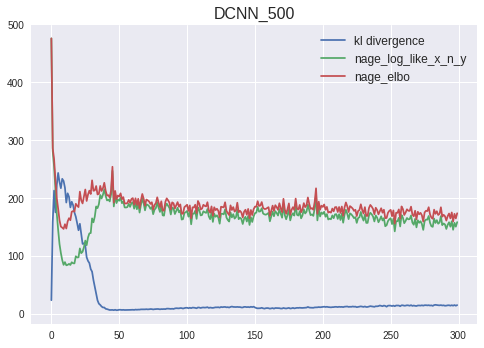

In [33]:
elbo_read = text_read('./result_DCNN_100_epoch_2/elbo_results.txt')
elbo_read = [float(elbo) for elbo in elbo_read]

kl_read = text_read('./result_DCNN_100_epoch_2/kl_results.txt')
kl_read = [float(kl) for kl in kl_read]

likei_read = text_read('./result_DCNN_100_epoch_2/likei_results.txt')
likei_read = [float(likei) for likei in likei_read]

plt.plot(kl_read, color = 'C0')
plt.plot(likei_read, color = 'C1')
plt.plot(elbo_read, color = 'C2')
plt.legend(['kl divergence','nage_log_like_x_n_y', 'nage_elbo'], fontsize=12)
plt.title("DCNN_500", fontsize=16)

## Load test data and test the model

### Test 1

In [34]:
################################################################################
######################## load test data ########################################
################################################################################


ind_small_txt = 12
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
print(en_file)
print(fr_file)
        
en_test, en_test_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_test, fr_test_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_test_batches, en_test_len_batches = batch_producer(en_test, en_test_len, batch_size) 
fr_test_batches, fr_test_len_batches = batch_producer(fr_test, fr_test_len, batch_size)
                       
################################################################################
############################### testing ########################################
################################################################################

kl_test_1 = []
nage_likeli_test_1 = []
objecti_test_1 = []
llx_test_1 = []
lly_test_1 = []

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    print("wa")
    
    ########### testing ###########
    for i in range(en_test_batches.shape[0]):
          
        discount_rate = 1
        
        test_feed_dict = {input_placeholder: en_test_batches[i], 
                     target_placeholder: fr_test_batches[i],
                     in_length_placeholder: en_test_len_batches[i], 
                     out_length_placeholder: fr_test_len_batches[i],
                     discount_placeholder: discount_rate,
                     if_gene_placeholder: False,
                     latent_var_placeholder: zero_latent}
        
        kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=test_feed_dict)       
                                   
        kl_test_1.append(kl)
        nage_likeli_test_1.append(nage_likeli)
        objecti_test_1.append(objecti)
        llx_test_1.append(llx)
        lly_test_1.append(lly)

print(np.mean(kl_test_1))
print(np.mean(nage_likeli_test_1))
print(np.mean(objecti_test_1))
print(np.mean(llx_test_1))
print(np.mean(lly_test_1))

../small_txt/12_en.txt
../small_txt/12_fr.txt
INFO:tensorflow:Restoring parameters from ./result_DCNN_100_epoch_2/model_each_epch.ckpt
wa
14.088301
176.21794
190.30624
-88.3593
-87.85864


### Test 2

In [35]:
################################################################################
######################## load test data ########################################
################################################################################

ind_small_txt = 11
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"
        
print(en_file)
print(fr_file)
        
en_test, en_test_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_test, fr_test_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_test_batches, en_test_len_batches = batch_producer(en_test, en_test_len, batch_size) 
fr_test_batches, fr_test_len_batches = batch_producer(fr_test, fr_test_len, batch_size)
                       
######## test set ########
kl_test_2 = []
nage_likeli_test_2 = []
objecti_test_2 = []
llx_test_2 = []
lly_test_2 = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    ########### training ###########
    for i in range(en_test_batches.shape[0]):
          
        discount_rate = 1
        
        test_feed_dict = {input_placeholder: en_test_batches[i], 
                          target_placeholder: fr_test_batches[i],
                          in_length_placeholder: en_test_len_batches[i], 
                          out_length_placeholder: fr_test_len_batches[i],
                          discount_placeholder: discount_rate,
                          lr_placeholder: learning_rate,
                          if_gene_placeholder: False,
                          latent_var_placeholder: zero_latent}
             
        kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=test_feed_dict)       
                                   
        kl_test_2.append(kl)
        nage_likeli_test_2.append(nage_likeli)
        objecti_test_2.append(objecti)
        llx_test_2.append(llx)
        lly_test_2.append(lly)

print(np.mean(kl_test_2))
print(np.mean(nage_likeli_test_2))
print(np.mean(objecti_test_2))
print(np.mean(llx_test_2))
print(np.mean(lly_test_2))

../small_txt/11_en.txt
../small_txt/11_fr.txt
INFO:tensorflow:Restoring parameters from ./result_DCNN_100_epoch_2/model_each_epch.ckpt
14.171515
177.78476
191.95627
-89.53014
-88.25461


### Sub-Train Set

In [37]:
ind_small_txt =  6
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)

######## test set ########
kl_test_3 = []
nage_likeli_test_3 = []
objecti_test_3 = []
llx_test_3 = []
lly_test_3 = []

zero_latent = np.zeros((latent_num, batch_size, max_length, latent_size))

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    print(en_file)
    print(fr_file)
    
    ########### training ###########
    for i in range(500):
          
        discount_rate = 1
        
        subtrain_feed_dict = {input_placeholder: en_input_batches[i], 
                     target_placeholder: fr_output_batches[i],
                     in_length_placeholder: en_input_len_batches[i], 
                     out_length_placeholder: fr_output_len_batches[i],
                     discount_placeholder: discount_rate,
                     if_gene_placeholder: False,
                     latent_var_placeholder: zero_latent}
       
        kl, nage_likeli, llx, lly, objecti = sess.run([kl_div_loss_batch_mean, nega_log_liki_x_y, log_liki_x_to, log_liki_y_to, objective], feed_dict=subtrain_feed_dict)       
                                   
        kl_test_3.append(kl)
        nage_likeli_test_3.append(nage_likeli)
        objecti_test_3.append(objecti)
        llx_test_3.append(llx)
        lly_test_3.append(lly)

print(np.mean(kl_test_3))
print(np.mean(nage_likeli_test_3))
print(np.mean(objecti_test_3))
print(np.mean(llx_test_3))
print(np.mean(lly_test_3))

INFO:tensorflow:Restoring parameters from ./result_DCNN_100_epoch_2/model_each_epch.ckpt
../small_txt/6_en.txt
../small_txt/6_fr.txt
14.650325
161.88243
176.53276
-82.05018
-79.83227


|                                       |  Sub-train     | Test 1        |   Test 2    |  Test    |  
|-----------------------------------|--------------------|-------------------|----------------|---------------|
|Reconstruction loss   | -161.87569 | -177.78476 |-176.21794  | -177.00135|
| Nega_logp(x\z)          |  -82.03589   | -89.53014  | -88.3593  |-88.94472 |
| Nega_logp(y\z)          |  -79.8398  |  -88.25461     | -87.85864 |-88.056625| 
|KL Divergence             | 14.650325 | 14.171515   |  14.0883 |14.1299|
|ELBO                             | -176.52602 |-191.95627   |-190.30624  |-191.13125|

## Generate sentence

In [0]:
ind_small_txt =  6
        
en_file = "../small_txt/" + str(ind_small_txt) + "_en.txt"
fr_file = "../small_txt/" + str(ind_small_txt) + "_fr.txt"

en_input, en_input_len = generate_input_en(en_file, en_word_to_id, max_length)
fr_output, fr_output_len = generate_output_fr(fr_file, fr_word_to_id, max_length)

en_input_batches, en_input_len_batches = batch_producer(en_input, en_input_len, batch_size) 
fr_output_batches, fr_output_len_batches = batch_producer(fr_output, fr_output_len, batch_size)

### Define functions

In [0]:
def find_next_word_beam_gene(logits_y, t):

  lower_ob = []
  for l in range(latent_num):           
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y) 
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l] 
  lower_ave = lower_to/latent_num
  
  return lower_ave

In [0]:
def id_to_word(words, word_to_id, max_length):
  k=0
  sens = ["" for x in range(max_length+1)]
  for key in word_to_id.keys():
    for p in range(max_length):
      if words[p] == word_to_id[key]:
        sens[p] = key
      if words[p] == word_to_id['eos'] and k==0:
        sen_len = p
        k=k+1
  return sens, sen_len

def output_sentence(idd,x_de,y_de):
  ########## "English" ##########
  origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("x:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(x_de[-1], en_word_to_id, max_length)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("x_re:")
  print(or_sens_str)
  
  en_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len], weights=[1,0,0,0])
  print(en_bleu)
  
  ########## "French" ##########
  origin_sens, ori_len = id_to_word(fr_output[idd], fr_word_to_id, max_length)
  or_sens_str = " "
  for p in range(ori_len):
     or_sens_str = or_sens_str + " " + origin_sens[p]
  print("y:")
  print(or_sens_str)

  or_sens, or_len = id_to_word(y_de[-1], fr_word_to_id, 30)
  or_sens_str = " "
  for p in range(or_len):
    or_sens_str = or_sens_str + " " + or_sens[p]
  print("y_re:")
  print(or_sens_str)
  
  fr_bleu = sentence_bleu([origin_sens[:ori_len]],or_sens[:or_len],weights=[1,0,0,0])
  print(fr_bleu)

## Case 9 \ 64 \ 68 \ 77 \ 78 \ 89

In [43]:
idd = 24
origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
or_sens_str = " "
for p in range(ori_len):
  or_sens_str = or_sens_str + " " + origin_sens[p]
print("x:")
print(or_sens_str)

x:
  In order to avoid problems arising again in the future on procedural timetables , it is necessary to improve the method for consulting the European Parliament , by setting


In [67]:
output_sentence(9,x_de,y_de)

x:
  I appeal for an in @-@ depth debate on this subject .
x_re:
  I would like to thank the rapporteur for his excellent work .
0.25


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Je demande qu&apos; un débat approfondi soit mené sur ce sujet .
y_re:
  par écrit . - ( EN ) J&apos; ai voté en faveur de ce rapport .
0.12500000000000003


In [63]:
output_sentence(64,x_de,y_de)

x:
  I also wish to thank Mr Almunia for the assistance he has given Cyprus all this time in achieving this objective .
x_re:
  I would like to thank Mr President , ladies and gentlemen , on behalf of the Committee on Civil Liberties , Justice and Home Affairs , on behalf of
0.1724137931034483


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Je voudrais également remercier M . Almunia pour l&apos; aide qu&apos; il a apportée à Chypre pendant tout ce temps en vue d&apos; atteindre cet objectif .
y_re:
  J&apos; ai voté en faveur de la mobilisation du Fonds européen d&apos; ajustement à la mondialisation ( FEM ) en faveur de la mobilisation du Fonds européen d&apos; ajustement
0.10344827586206899


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [65]:
output_sentence(89,x_de,y_de)

x:
  It is a mechanism that we have criticised here , in this Parliament , and that , I think , we continue to criticise .
x_re:
  It is an important step towards the freedom of expression of the European Union .
0.1026834238065184


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  C&apos; est un mécanisme que nous avons critiqué ici , dans ce Parlement , et que , je pense , nous continuons de critiquer .
y_re:
  C&apos; est pourquoi j&apos; ai voté en faveur de ce rapport .
0.14102726046114258


In [51]:
output_sentence(77,x_de,y_de)

x:
  The issue of the euro is no small matter for our fellow citizens : it is , in their hands , one of the European Union &apos;s most valuable
x_re:
  on behalf of the ECR Group . - Mr President , I would like to thank my fellow Members .
0.12752563032435468


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  L&apos; affaire de l&apos; euro n&apos; est pas une petite affaire pour nos concitoyens : c&apos; est , entre leurs mains , un des biens les plus précieux de
y_re:
  par écrit . - ( EN ) J&apos; ai voté en faveur de ce rapport .
0.027734206880067492


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [53]:
output_sentence(78,x_de,y_de)

x:
  Since last year , however , since the opening of the debate on the accession of Lithuania , we have had the impression that it has become a debate
x_re:
  in writing . - I voted in favour of this motion for a resolution on the mobilisation of the European Globalisation Adjustment Fund ( EGF ) in favour of
0.20689655172413796


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Pourtant , depuis l&apos; année dernière , depuis l&apos; ouverture du débat sur l&apos; adhésion de la Lituanie , nous avons l&apos; impression qu&apos; il est devenu un débat
y_re:
  par écrit . - ( EN ) J&apos; ai voté en faveur de ce rapport sur la mobilisation du Fonds européen d&apos; ajustement à la mondialisation ( FEM )
0.13793103448275862


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [46]:
output_sentence(24,x_de,y_de)

x:
  In order to avoid problems arising again in the future on procedural timetables , it is necessary to improve the method for consulting the European Parliament , by setting
x_re:
  on behalf of the S &amp; D Group . - Mr President , I would like to thank the rapporteur for his excellent work .
0.20451450935189075


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  Afin d&apos; éviter que des problèmes surviennent encore à l&apos; avenir concernant le calendrier de procédure , il y a lieu d&apos; améliorer la méthode de consultation du Parlement
y_re:
  par écrit . - ( EN ) J&apos; ai voté en faveur de ce rapport parce que j&apos; ai voté en faveur de ce rapport parce que je pense
0.10344827586206899


In [48]:
output_sentence(77,x_de,y_de)

x:
  The issue of the euro is no small matter for our fellow citizens : it is , in their hands , one of the European Union &apos;s most valuable
x_re:
  on behalf of the Group of the European People &apos;s Party ( Christian Democrats ) .
0.16640524128040496


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


y:
  L&apos; affaire de l&apos; euro n&apos; est pas une petite affaire pour nos concitoyens : c&apos; est , entre leurs mains , un des biens les plus précieux de
y_re:
  par écrit . - ( EN ) J&apos; ai voté en faveur de ce rapport .
0.027734206880067492


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


### Beam Search

In [0]:
idd = 4
origin_sens, ori_len = id_to_word(en_input[idd], en_word_to_id, max_length)
or_sens_str = " "
for p in range(ori_len):
  or_sens_str = or_sens_str + " " + origin_sens[p]
print("x:")
print(or_sens_str)

origin_sens, ori_len = id_to_word(fr_output[idd], fr_word_to_id, max_length)
or_sens_str = " "
for p in range(ori_len):
  or_sens_str = or_sens_str + " " + origin_sens[p]
print("y:")
print(or_sens_str)

In [47]:
########## Beam Search gene x ###########

beam_size = 30
conti = True
idd = 77
t = 0
decode_len = 30

eos_id = en_word_to_id['eos']
eos_prob = -float('Inf')

x_in = np.reshape(np.copy(en_input[idd]), (1, max_length))
y_in = np.reshape(np.copy(fr_output[idd]), (1, max_length))

x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))
y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))

x_len = np.reshape(np.copy(en_input_len[idd]), (1,))
y_len = np.reshape(np.copy(fr_output_len[idd]), (1,))

#########################################################
x_prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(x_de.shape, dtype=np.int32)
x_score = np.zeros((beam_size))

y_prob_next_word = np.ones((beam_size, fr_vocab_size),dtype=np.float32)
y_de_new = np.zeros(y_de.shape, dtype=np.int32)
y_score = np.zeros((beam_size))

#########################################################

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
       
    for t in range(decode_len):
      
        for j in range(beam_size):
          gene_feed_dict = {latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length)),
                            target_placeholder: np.reshape(y_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)
          
          logits_y = sess.run(logits_gene_y_to, feed_dict=gene_feed_dict)
            
          x_prob_next_word[j] = find_next_word_beam_gene(logits_x, t)          
          
          x_prob_next_word[j] = x_prob_next_word[j] + x_score[j]
          
          y_prob_next_word[j] = find_next_word_beam_gene(logits_y, t)          
          
          y_prob_next_word[j] = y_prob_next_word[j] + y_score[j]
        
        
        x_beam_id = np.argmax(x_prob_next_word, axis=0)
        
        x_prob_next_word_beam = np.max(x_prob_next_word, axis=0)
        
        x_next_word_id = np.argsort(x_prob_next_word_beam[2:])[-beam_size:] + 2
        
        y_beam_id = np.argmax(y_prob_next_word, axis=0)
        
        y_prob_next_word_beam = np.max(y_prob_next_word, axis=0)
        
        y_next_word_id = np.argsort(y_prob_next_word_beam[2:])[-beam_size:] + 2
        
        
        for j in range(beam_size):
          
          x_beam_id_j = x_beam_id[x_next_word_id[j]]
          
          x_word_id_j = x_next_word_id[j]
          
          x_de_new[j] = copy.deepcopy(x_de[x_beam_id_j])
              
          x_de_new[j,t] = copy.deepcopy(x_word_id_j)
          
          x_score[j] = copy.deepcopy(x_prob_next_word_beam[x_word_id_j])
          
          
          y_beam_id_j = y_beam_id[y_next_word_id[j]]
          
          y_word_id_j = y_next_word_id[j]
          
          y_de_new[j] = copy.deepcopy(y_de[y_beam_id_j])
              
          y_de_new[j,t] = copy.deepcopy(y_word_id_j)
          
          y_score[j] = copy.deepcopy(y_prob_next_word_beam[y_word_id_j])
        
        x_de = copy.deepcopy(x_de_new)
        y_de = copy.deepcopy(y_de_new)

INFO:tensorflow:Restoring parameters from ./result_DCNN_100_epoch_2/model_each_epch.ckpt


### Blue Score Functions

In [0]:
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def sel_sentence_bleu(candidate, references):
    precisions = []
    for i in range(4):
        pr, bp = count_ngram(candidate, references, i+1)
        precisions.append(pr)
    bleu = geometric_mean(precisions) * bp
    return bleu

## Translate Sentence

### Define functions

In [0]:
def find_next_word_beam_tran(logits_y, latent_score, t):

  lower_ob = []
  for l in range(latent_num):           
    #y_max = np.max(logits_y[l,t])
    prob_y = np.exp(logits_y[l,t])/np.sum(np.exp(logits_y[l,t]))    
    log_prob_y_t = np.log(prob_y)     
    lower_ob.append(log_prob_y_t)
  
  lower_to = 0
  for l in range(latent_num):
    lower_to = lower_to + lower_ob[l]  + latent_score[l]
  lower_ave = lower_to/latent_num
  
  return lower_ave,  lower_ob

In [0]:
########## Beam Search translate ###########

beam_size = 30

x_in = np.reshape(np.copy(en_test[2]), (1, max_length))
y_in = np.reshape(np.copy(fr_test[2]), (1, max_length))

y_de = np.random.randint(low=0, high=fr_vocab_size, size=(beam_size, max_length))
x_de = np.random.randint(low=0, high=en_vocab_size, size=(beam_size, max_length))

#########################################################
prob_next_word = np.ones((beam_size, en_vocab_size),dtype=np.float32)
x_de_new = np.zeros(y_de.shape, dtype=np.int32)

x_len = np.reshape(np.copy(en_test_len[2]), (1,))
y_len = np.reshape(np.copy(fr_test_len[2]), (1,))

score = np.zeros((beam_size))
latent_score = np.zeros((latent_num))
current_prob = np.zeros((beam_size, en_vocab_size))

with tf.Session() as sess:
  
    saver = tf.train.Saver()
    saver.restore(sess, path1)
    
    gene_feed_dict = {input_placeholder: x_in, 
                      target_placeholder: y_in,
                      in_length_placeholder: x_len, 
                      out_length_placeholder: y_len}                           
            
    mean, std = sess.run([la_mean, la_std], feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    la_var = []
    log_prob_la = []
    for _ in range(latent_num):
      eposida = np.random.normal(size = np.shape(la_std), loc=0.0, scale=1)
      la_var_sample = mean + std*eposida
      la_var_sample = np.reshape(la_var_sample, (batch_size, max_length, latent_size))    # batch_size x max_length x latent_size
      la_var.append(la_var_sample)
      log_prob_la.append(np.sum(np.log(norm.pdf(la_var_sample))))
    
    gene_feed_dict = {latent_var_placeholder:la_var,
                      target_placeholder: y_in,
                      out_length_placeholder: y_len}                           
            
    log_y = sess.run(log_liki_y_to, feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
    
    
    for i in range(latent_num):
      latent_score[i] = log_prob_la[i] + log_y[i]
    
    for t in range(10):      
        for j in range(beam_size):
          gene_feed_dict = {if_gene_placeholder: True,
                            latent_var_placeholder:la_var,
                            input_placeholder: np.reshape(x_de[j], (1,max_length))}
                                                                           
          logits_x = sess.run(logits_gene_x_to, feed_dict=gene_feed_dict)    # 1*max_len x fr_vocab_size
            
          prob_next_word[j], current_prob[j]  = find_next_word_beam_first(logits_x, latent_score, t)          
          
        
        beam_max_id = np.argmax(prob_next_word, axis=0)
        beam_max = np.max(prob_next_word, axis=0)
        
        next_beam_id = np.argsort(beam_max)[-beam_size:]
        
        score_new = np.zeros((beam_size))
        
        for j in range(beam_size):
          beam_id = beam_max_id[next_beam_id[j]]
          x_de_new[j] = x_de[beam_id]
          x_de_new[j,t] = next_beam_id[j]
          score_new[j] =  latent_score[beam_id] + current_prob[beam_id, next_beam_id[j]]
        
        x_de = x_de_new
        latent_score = score_new
        
    print(np.mean(latent_score))